## Problem statement:
Given a dataset of energy consumed every hour for the years 2010 - 2018, arrive at an approach
which will help us predict the energy requirement for a day in the future.

**Set up environment**

In [1]:
!pip install statsmodels
import pandas as pd
import tensorflow as tf
import holidays
import joblib
import random
from prophet.serialize import model_to_json, model_from_json


import numpy as np

from  scipy.stats import skew, kurtosis, shapiro

import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import datetime as dt


try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.


**Preprocess data**

In [2]:
class PreProcess:
    def __init__(self,data_path):
        data = pd.read_csv(data_path, sep=",")[['Datetime','Power_MWH']]
        data['Datetime'] = pd.to_datetime(data['Datetime'])
        data = data.groupby(data['Datetime'].dt.date)['Power_MWH'].sum()
        data = data.asfreq("D")
        data = data.reset_index()
        data.columns = ['date', 'energy']
        self.df = data
        

                
      

       


In [3]:
pre_process = PreProcess("power_data.csv")


**Data Analysis**

aset

In [4]:
plt.style.use('fivethirtyeight') # For plots

In [5]:
def plot_decompose(decompose_result):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,20))
    decompose_result.observed.plot(legend=False,ax=ax1,fontsize = 20,grid=True,linewidth = 3)
    ax1.set_ylabel("Observed",fontsize = 20)
    decompose_result.trend.plot(legend=False,ax=ax2,fontsize = 20,grid=True,linewidth = 3)
    ax2.set_ylabel("Trend",fontsize = 20)
    decompose_result.seasonal.plot(legend=False,ax=ax3,fontsize = 20,grid=True,linewidth = 3)
    ax3.set_ylabel("Seasonal",fontsize = 20)
    decompose_result.resid.plot(legend=False,ax=ax4,fontsize = 20,grid=True,linewidth = 3)
    ax4.set_ylabel("Residual",fontsize = 20)

In [6]:
data = pre_process.df.set_index('date')

In [7]:
data.info() 
data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3137 entries, 2010-01-01 to 2018-08-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   energy  3137 non-null   int64
dtypes: int64(1)
memory usage: 49.0 KB


,energy
date,
2010-01-01,750586
2010-01-02,837421
2010-01-03,910921
2010-01-04,933310
2010-01-05,915793
...,...
2018-07-30,790978
2018-07-31,828938
2018-08-01,941539


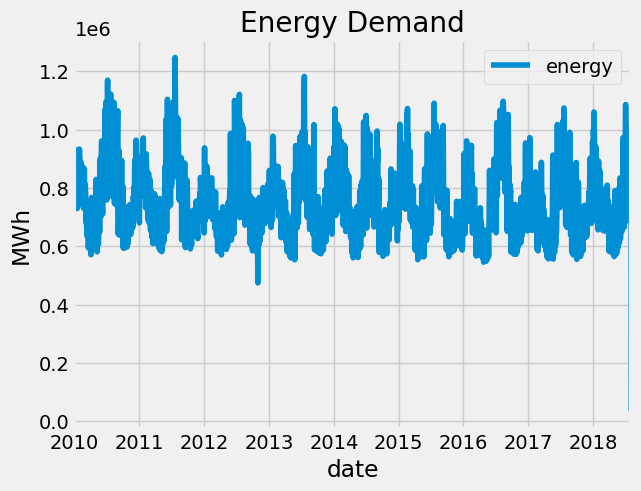

In [8]:
data.plot(title="Energy Demand")
plt.ylabel("MWh")
plt.show()

C:\Users\vudod\AppData\Local\Temp\ipykernel_19328\1605245011.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week


<Figure size 2000x1600 with 0 Axes>

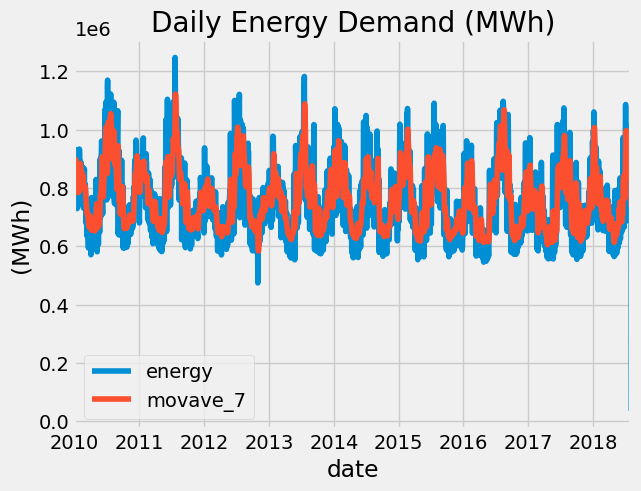

In [9]:
data["year"] = data.index.year
data["qtr"] = data.index.quarter
data["mon"] = data.index.month
data["week"] = data.index.week
data["day"] = data.index.weekday
data["ix"] = range(0,len(data))
data[["movave_7", "movstd_7"]] = data.energy.rolling(7).agg([np.mean, np.std])
data[["movave_30", "movstd_30"]] = data.energy.rolling(30).agg([np.mean, np.std])
data[["movave_90", "movstd_90"]] = data.energy.rolling(90).agg([np.mean, np.std])
data[["movave_365", "movstd_365"]] = data.energy.rolling(365).agg([np.mean, np.std])

plt.figure(figsize=(20,16))
data[["energy", "movave_7"]].plot(title="Daily Energy Demand (MWh)")
plt.ylabel("(MWh)")
plt.show()


**EDA: Exploratory Data Analysis**

* Target Analyisis: Normality

In [10]:
mean = np.mean(data.energy.values)
std = np.std(data.energy.values)
skew = skew(data.energy.values)
ex_kurt = kurtosis(data.energy)
print("Skewness: {} \nKurtosis: {}".format(skew, ex_kurt+3))

Skewness: 0.5944429910181976 
Kurtosis: 3.516682786533853


* Skewness is 0.59: Positive skewness means that the tail of the distribution is skewed to the right, indicating that there are more values on the left side of the distribution with a few extreme values on the right side. In other words, the distribution has a longer right tail. 
A skewness value of 0.59 is relatively small, indicating a mild positive skew. The magnitude of skewness can range from -1 to +1, where values closer to 0 suggest a more symmetrical distribution. Therefore, a skewness value of 0.59 indicates a slight departure from perfect symmetry, with a tendency towards more values on the left side of the distribution.s.on.

* Kurtosis greater than 3: Positive excess kurtosis means that the distribution has heavier tails and more extreme outliers compared to a normal distribution. It suggests that there is a higher probability of observing extreme values in the data. A kurtosis value of 3.51 is relatively high, indicating a distribution that is more peaked and has fatter tails than a normal distribution. This means that the data has a greater proportion of values that are farther away from the mean, resulting in more extreme values.

C:\Users\vudod\AppData\Local\Temp\ipykernel_19328\16411889.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.energy)


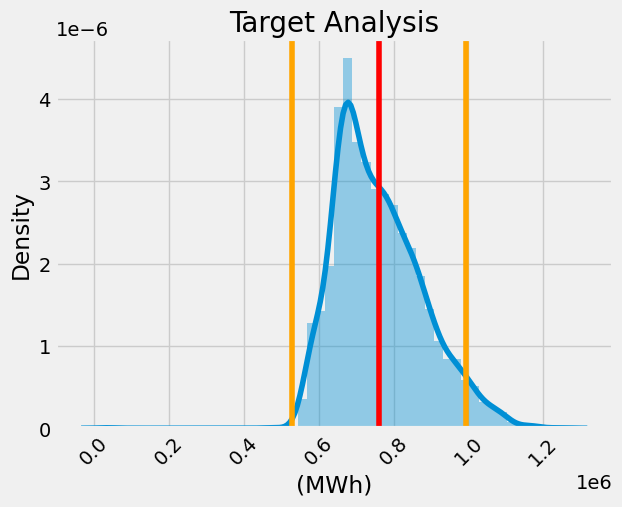

In [11]:
sns.distplot(data.energy)
plt.title("Target Analysis")
plt.xticks(rotation=45)
plt.xlabel("(MWh)")
plt.axvline(x=mean, color='r', linestyle='-', label="\mu: {0:.2f}%".format(mean))
plt.axvline(x=mean+2*std, color='orange', linestyle='-')
plt.axvline(x=mean-2*std, color='orange', linestyle='-')
plt.show()

Broadly speaking, data does not look like a normal distribution, because it has a small left tail and the chance of observing extreme values is smaller, comparing to normally distributed data



**Volatility Analysis**


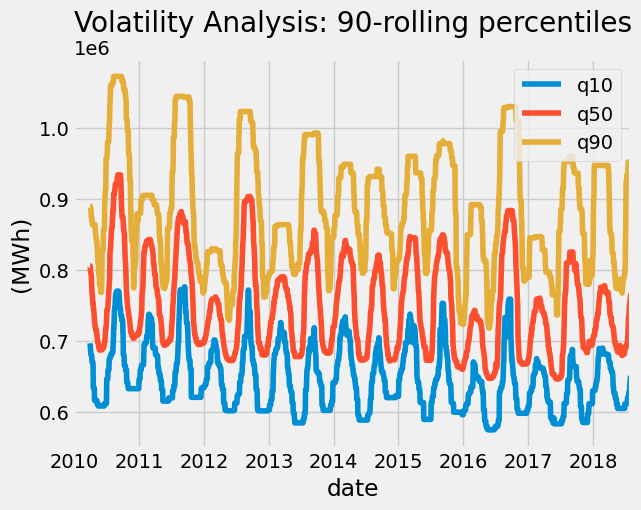

In [12]:
# Insert the rolling quantiles to the monthly returns
data_rolling = data.energy.rolling(window=90)
data['q10'] = data_rolling.quantile(0.1).to_frame("q10")
data['q50'] = data_rolling.quantile(0.5).to_frame("q50")
data['q90'] = data_rolling.quantile(0.9).to_frame("q90")

data[["q10", "q50", "q90"]].plot(title="Volatility Analysis: 90-rolling percentiles")
plt.ylabel("(MWh)")
plt.show()

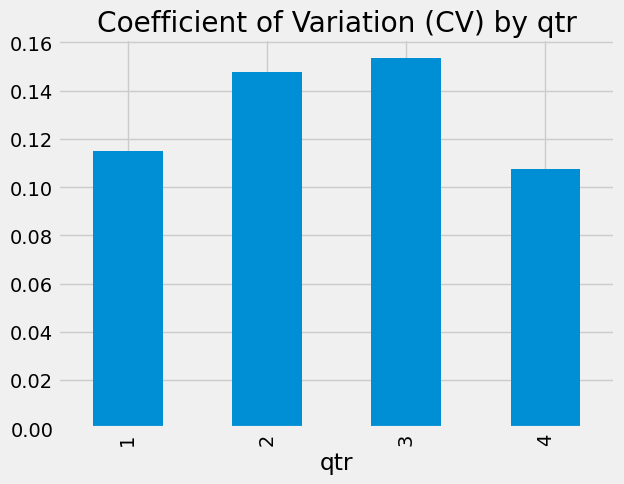

In [13]:
data.groupby("qtr")["energy"].std().divide(data.groupby("qtr")["energy"].mean()).plot(kind="bar")
plt.title("Coefficient of Variation (CV) by qtr")
plt.show()

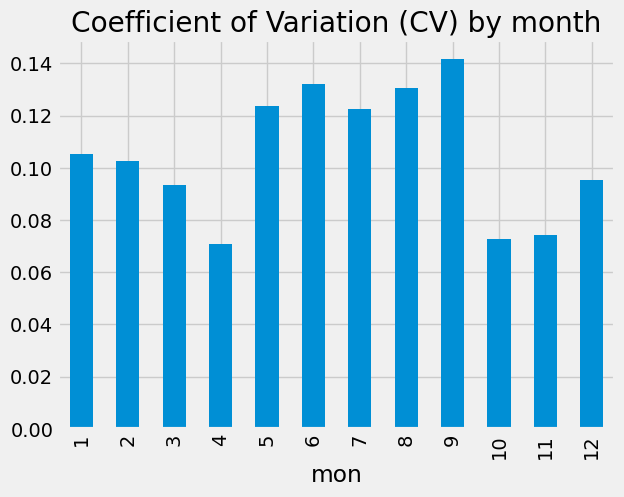

In [14]:
data.groupby("mon")["energy"].std().divide(data.groupby("mon")["energy"].mean()).plot(kind="bar")
plt.title("Coefficient of Variation (CV) by month")
plt.show()

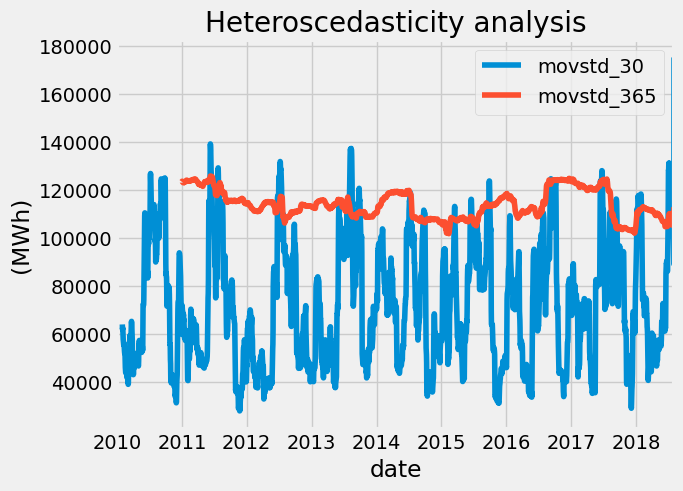

In [15]:
data[["movstd_30", "movstd_365"]].plot(title="Heteroscedasticity analysis")
plt.ylabel("(MWh)")
plt.show()

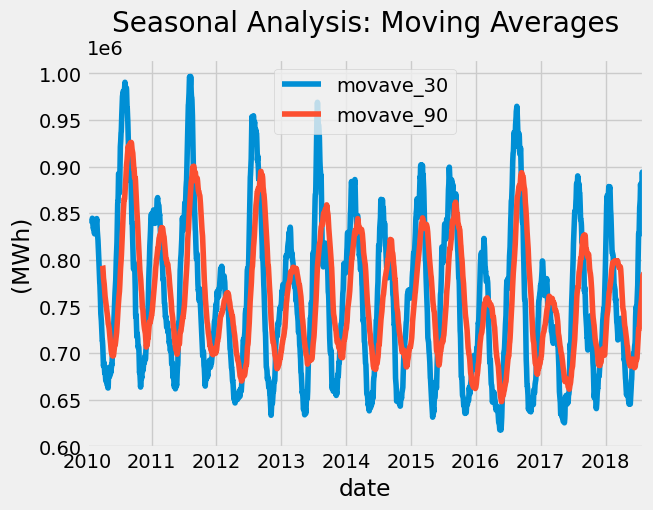

In [16]:
data[["movave_30", "movave_90"]].plot(title="Seasonal Analysis: Moving Averages")
plt.ylabel("(MWh)")
plt.show()

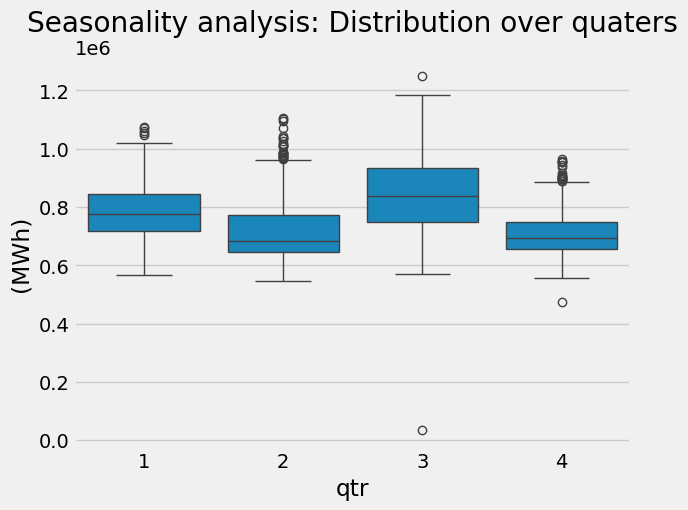

In [17]:
sns.boxplot(data=data, x="qtr", y="energy")
plt.title("Seasonality analysis: Distribution over quaters")
plt.ylabel("(MWh)")
plt.show()

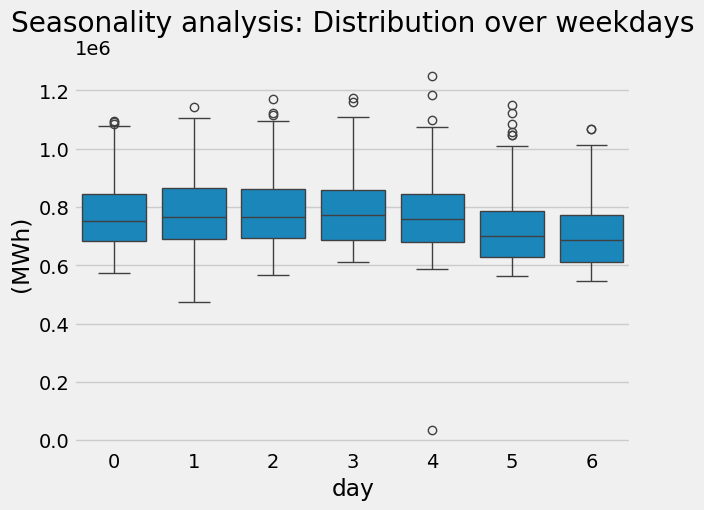

In [18]:
sns.boxplot(data=data, x="day", y="energy")
plt.title("Seasonality analysis: Distribution over weekdays")
plt.ylabel("(MWh)")
plt.show()

In [19]:
data_mon = data.energy.resample("M").agg(sum).to_frame("energy")
data_mon["ix"] = range(0, len(data_mon))
data_mon[:5]

,energy,ix
date,,
2010-01-31,26032810,0
2010-02-28,23282363,1
2010-03-31,22128750,2
2010-04-30,19882493,3
2010-05-31,22336022,4


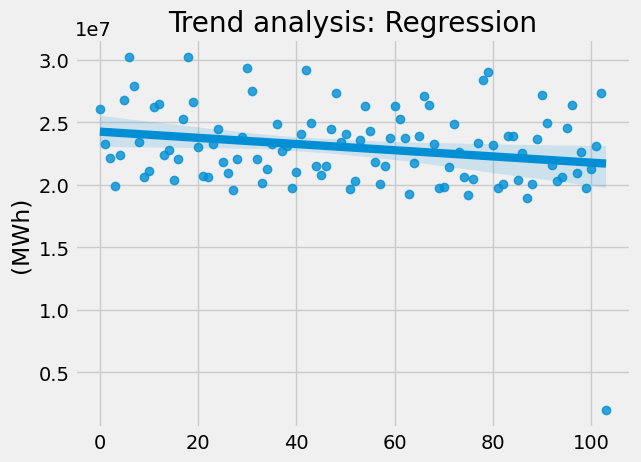

In [20]:
sns.regplot(data=data_mon,x="ix", y="energy")
plt.title("Trend analysis: Regression")
plt.ylabel("(MWh)")
plt.xlabel("")
plt.show()

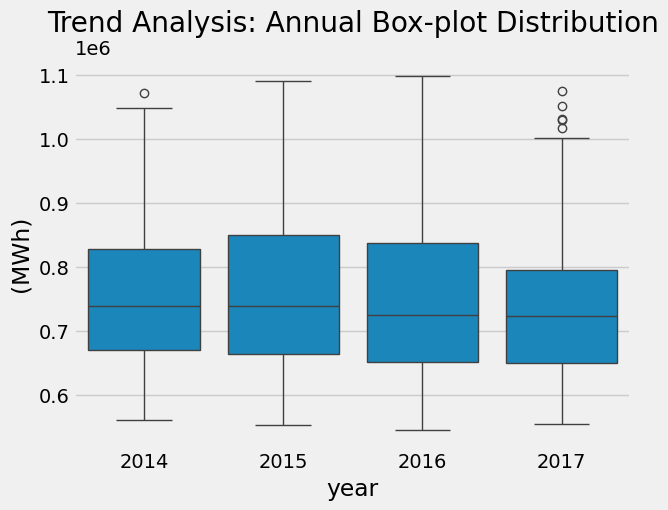

In [21]:
sns.boxplot(data=data["2014":"2017"], x="year", y="energy")
plt.title("Trend Analysis: Annual Box-plot Distribution")
plt.ylabel("(MWh)")
plt.show()

**Feature Engineering**

The challenge now is to create some features in a very automated way that can deal with seasonality, trend and changes in volatility. The most basic strategy is to use lagged features and rolling window stats, but consider other advanced techniques for further research:

Momentum and Mean reversion, like RSI in financial markets (https://en.wikipedia.org/wiki/Relative_strength_index)
Sequence minning
Data is standardized in order to allow application of models that are sensitive to scale, like neural networks or svm. Remember that distribution shape is maintained, it only changes first and second momentum (mean and standard deviation)

C:\Users\vudod\AppData\Local\Temp\ipykernel_19328\1426062513.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data["target"])


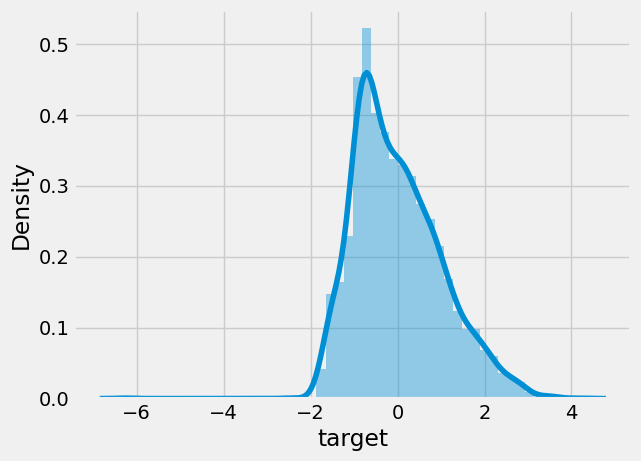

In [22]:
data["target"] = data.energy.add(-mean).div(std)
sns.distplot(data["target"])
plt.show()

In [23]:
features = []
corr_features=[]
targets = []
tau = 30 #forecasting periods

for t in range(1, tau+1):
    data["target_t" + str(t)] = data.target.shift(-t)
    targets.append("target_t" + str(t))
    
for t in range(1,31):
    data["feat_ar" + str(t)] = data.target.shift(t)
    #data["feat_ar" + str(t) + "_lag1y"] = data.target.shift(350)
    features.append("feat_ar" + str(t))
    #corr_features.append("feat_ar" + str(t))
    #features.append("feat_ar" + str(t) + "_lag1y")
        
    
for t in [7, 14, 30]:
    data[["feat_movave" + str(t), "feat_movstd" + str(t), "feat_movmin" + str(t) ,"feat_movmax" + str(t)]] = data.energy.rolling(t).agg([np.mean, np.std, np.max, np.min])
    features.append("feat_movave" + str(t))
    #corr_features.append("feat_movave" + str(t))
    features.append("feat_movstd" + str(t))
    features.append("feat_movmin" + str(t))
    features.append("feat_movmax" + str(t))
    
months = pd.get_dummies(data.mon,
                              prefix="mon",
                              drop_first=True)
months.index = data.index
data = pd.concat([data, months], axis=1)

days = pd.get_dummies(data.day,
                              prefix="day",
                              drop_first=True)
days.index = data.index
data = pd.concat([data, days], axis=1)


features = features + months.columns.values.tolist() + days.columns.values.tolist()

In [24]:
corr_features = ["feat_ar1", "feat_ar2", "feat_ar3", "feat_ar4", "feat_ar5", "feat_ar6", "feat_ar7", "feat_movave7", "feat_movave14", "feat_movave30"]

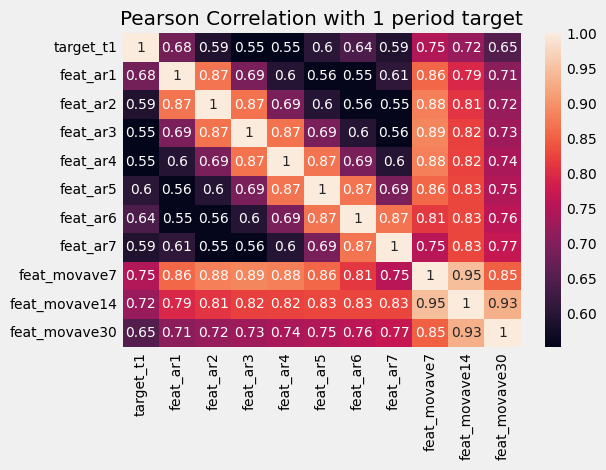

In [25]:
# Calculate correlation matrix
corr = data[["target_t1"] + corr_features].corr()

top5_mostCorrFeats = corr["target_t1"].apply(abs).sort_values(ascending=False).index.values[:6]
plt.rcParams.update({'font.size': 10})


# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True)
plt.title("Pearson Correlation with 1 period target")
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot

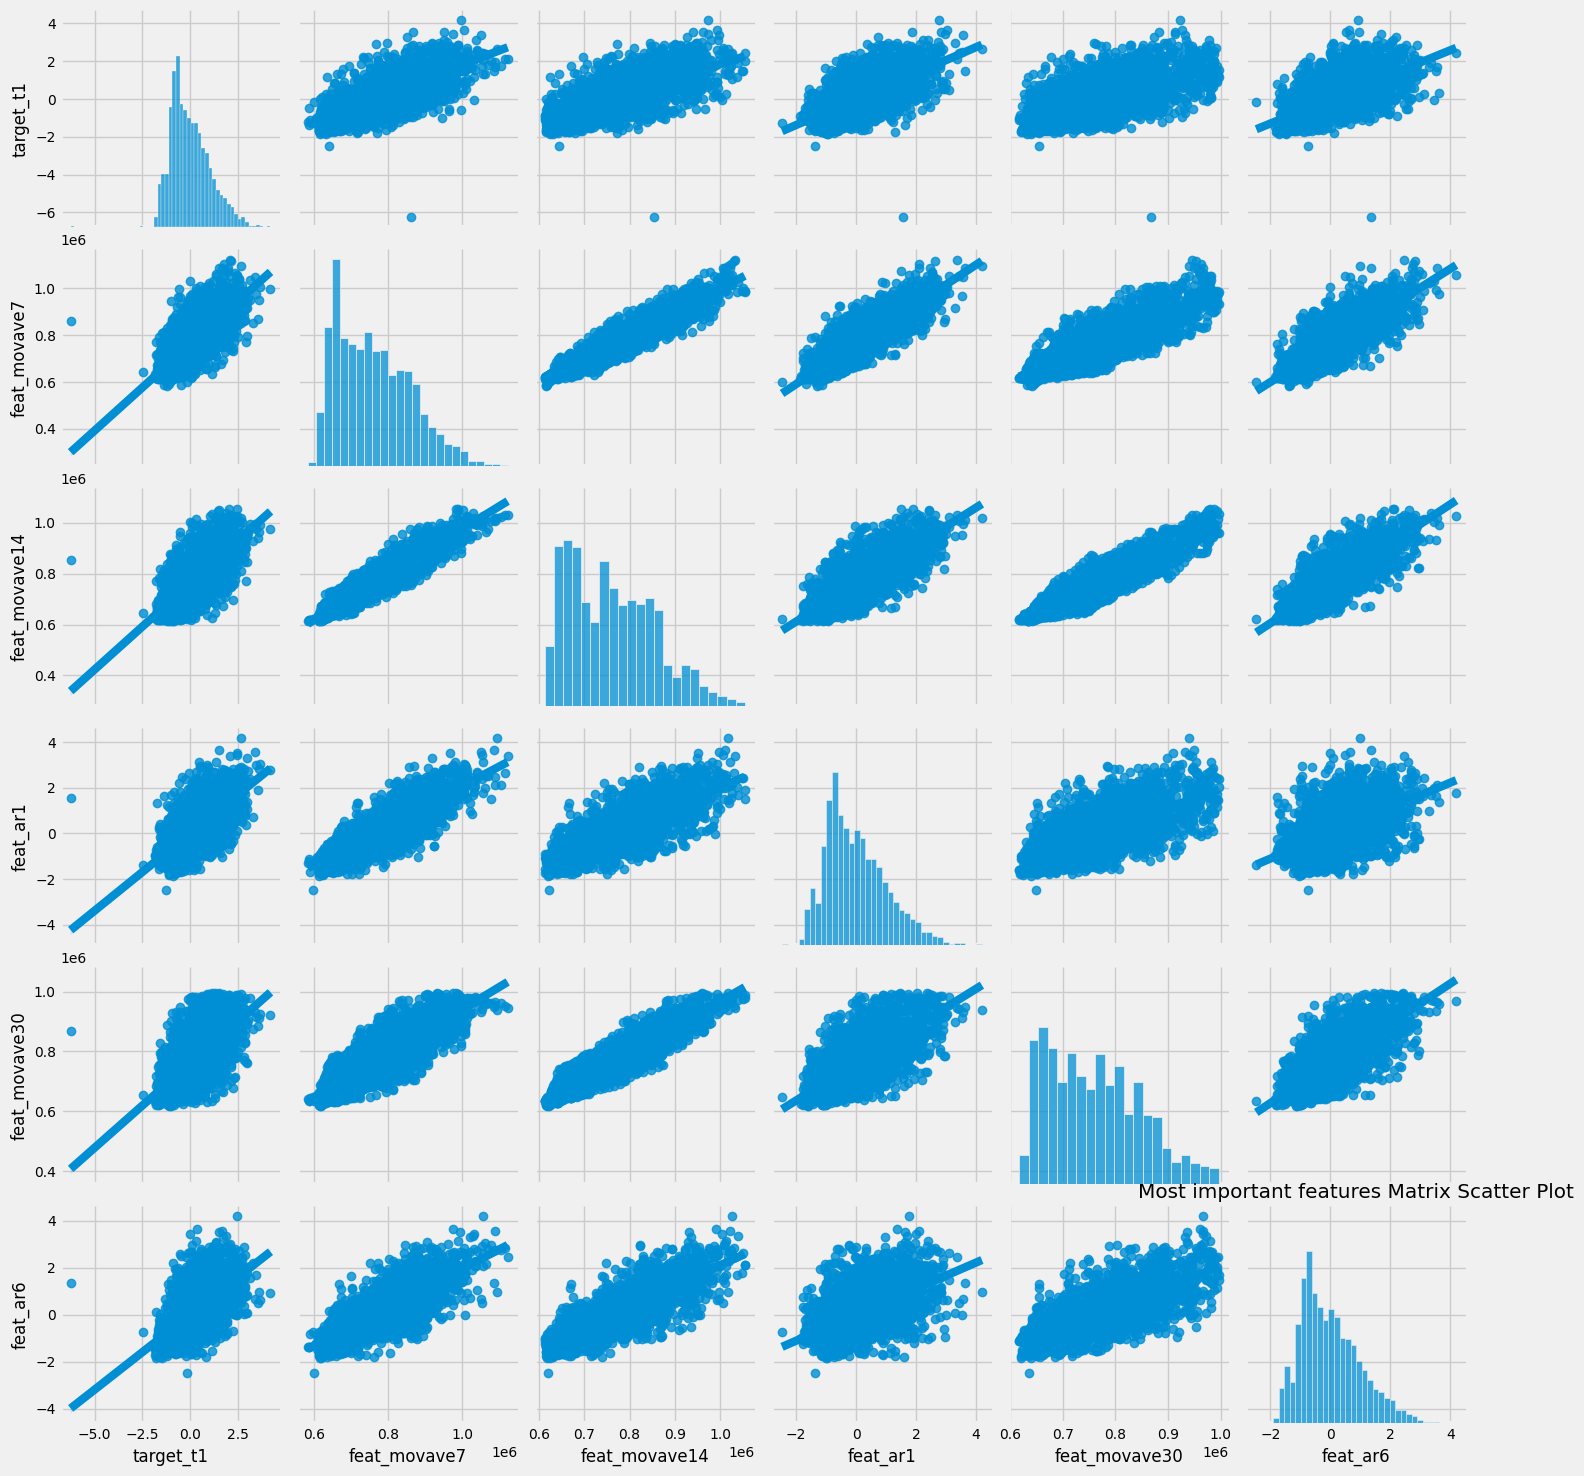

In [26]:
sns.pairplot(data=data[top5_mostCorrFeats].dropna(), kind="reg")
plt.title("Most important features Matrix Scatter Plot")
plt.show()

## Model Building


In this step, two candidates models are build using an nice feature in Scikit-Learn such us MultiOutput Regression, it provides a framework to automatically and easily fit models to predict several target variables. (https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html)

First a baseline model (linear regression) will be fit and compared to a more advanced model, like Random Forest. A linear model does not need hyperparamenter tunning, and there is some correlation in data, so it is a strongh foundation, but there are several caveats:

Target variable is not perfectly normally distributed with constant variance
There are a lot of multicollinearity among predictors
Observations are not independent
On the other hand an advanced model, like Random Forest, needs to perform hyperparamenter tunning, tipically it is solved by using GridSearch and Cross Validation, but time series data is not suitable to be used in CV, because data is shuffled in order to build k-folds. On the other hand, Scikit-Learng provide us with a nice solution: TimeSeries Splits, that respect time structure of date and iterativelly allow us to perform GridSearch

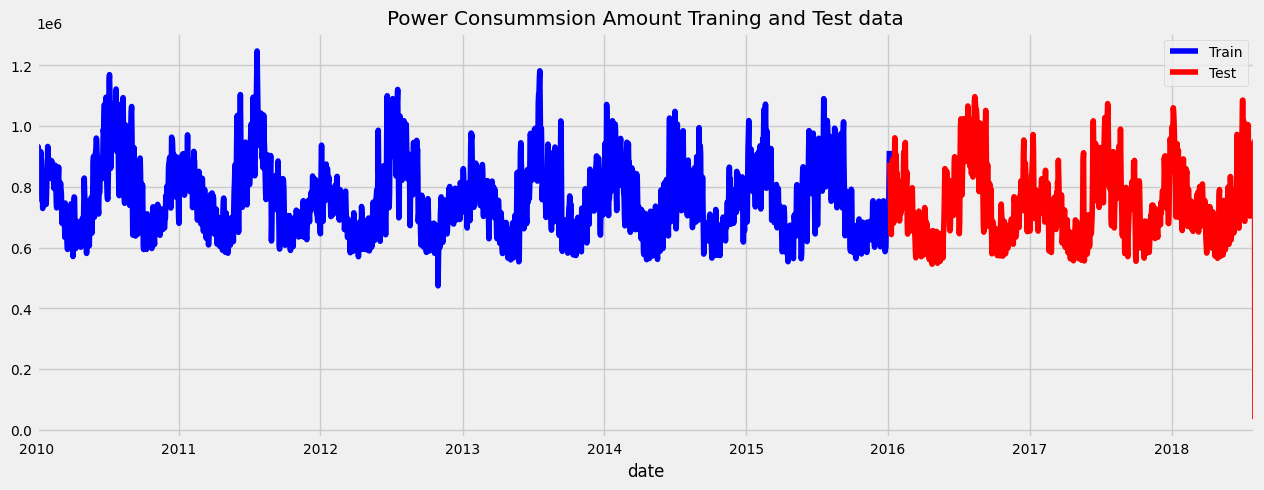

In [27]:
ratio = 0.3

dff = pre_process.df
num_rows = int(len(dff) * ratio)
test_data = dff.tail(num_rows)
train_data = dff.head(len(dff) - num_rows)

pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
train_data.plot(kind='line', x='date', y='energy', color='blue', label='Train', ax=ax)
test_data.plot(kind='line', x='date', y='energy', color='red', label='Test', ax=ax)
plt.title('Power Consummsion Amount Traning and Test data')
plt.show()

Number of observations:  3077
Total number of observations:  3077
Train: (2214, 59)(2214, 30), 
Test: (923, 59)(923, 30)


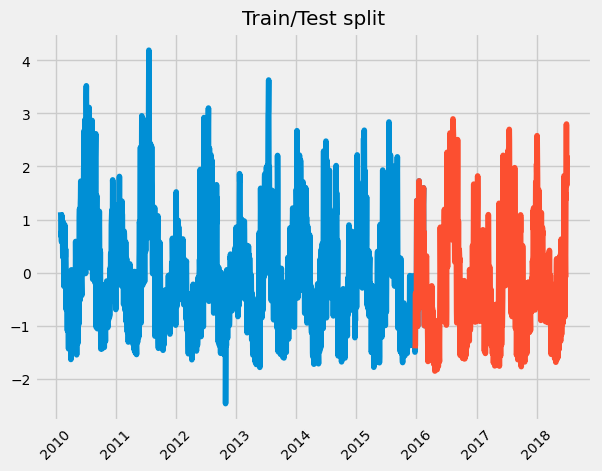

In [28]:
data_feateng = data[features + targets].dropna()
nobs= len(data_feateng)
print("Number of observations: ", nobs)
num_rows = int(len(data_feateng) * ratio)
df_test = data_feateng.tail(num_rows)
df_train = data_feateng.head(len(dff) - num_rows)

X_train = df_train[features]
y_train = df_train[targets]

X_test = df_test[features]
y_test = df_test[targets]

n, k = X_train.shape
print("Total number of observations: ", nobs)
print("Train: {}{}, \nTest: {}{}".format(X_train.shape, y_train.shape,
                                              X_test.shape, y_test.shape))

plt.plot(y_train.index, y_train.target_t1.values, label="train")
plt.plot(y_test.index, y_test.target_t1.values, label="test")
plt.title("Train/Test split")
plt.xticks(rotation=45)
plt.show()

**Baseline Model: Linear Regression**


In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

reg = LinearRegression().fit(X_train, y_train["target_t1"])
p_train = reg.predict(X_train)
p_test = reg.predict(X_test)


RMSE_train = np.sqrt(mean_squared_error(y_train["target_t1"], p_train))
RMSE_test = np.sqrt(mean_squared_error(y_test["target_t1"], p_test))

MAE = mean_absolute_error(np.array(y_test['target_t1']), p_test)
MAPE_BL = mean_absolute_percentage_error(np.array(y_test['target_t1']), p_test)
print("Train RMSE: {}\nTest RMSE: {}".format(RMSE_train, RMSE_test) )
print(f"MAE: {MAE}")
print(f"MAPE: {MAPE_BL}")



Train RMSE: 0.3515539700910657
Test RMSE: 0.3811205337046227
MAE: 0.28776074264266854
MAPE: 1.6886425576058097


TRAIN: 555 TEST: 553


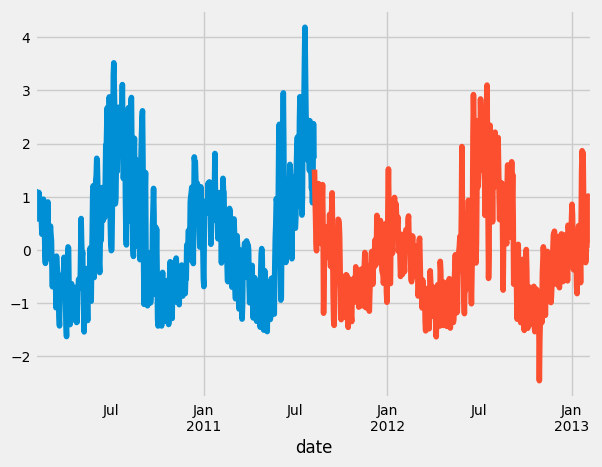

TRAIN: 730 TEST: 553


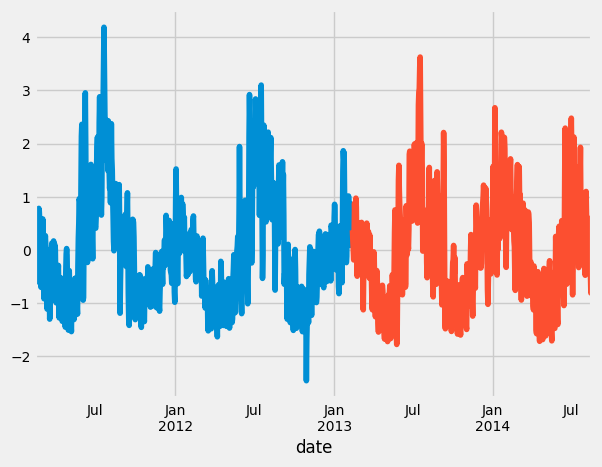

TRAIN: 730 TEST: 553


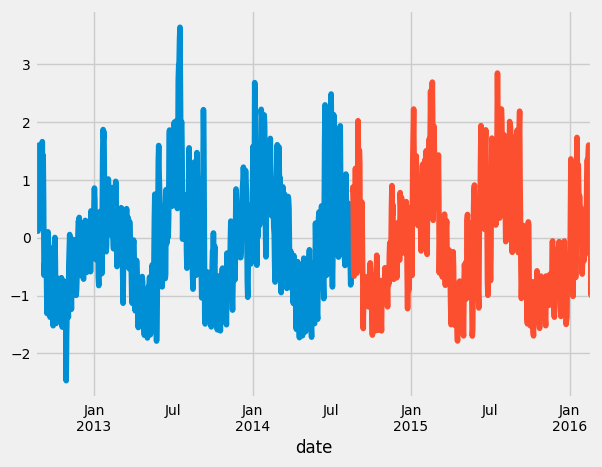

In [30]:
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid

splits = TimeSeriesSplit(n_splits=3, max_train_size=365*2)
for train_index, val_index in splits.split(X_train):
    print("TRAIN:", len(train_index), "TEST:", len(val_index))
    y_train["target_t1"][train_index].plot()
    y_train["target_t1"][val_index].plot()
    plt.show()
   

dSearch

In [31]:
from sklearn.ensemble import RandomForestRegressor

splits = TimeSeriesSplit(n_splits=3, max_train_size=365*2)
rfr = RandomForestRegressor()
# Create a dictionary of hyperparameters to search
rfr_grid = {"n_estimators": [500], 
        'max_depth': [3, 5, 10, 20, 30], 
        'max_features': [4, 8, 16, 32, 59], 
        'random_state': [123]}
rfr_paramGrid = ParameterGrid(rfr_grid)

def TimeSplit_ModBuild(model, paramGrid, splits, X, y):
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import mean_squared_error

    #Loop over each time split and for each
    for train_index, val_index in splits.split(X_train):
        _X_train_ = X.iloc[train_index]
        _y_train_ = y.iloc[train_index]
        _X_val_ = X.iloc[val_index]
        _y_val_ = y.iloc[val_index]

        train_scores = []
        val_scores = []
        #models = []
        
        # Loop through the parameter grid, set the hyperparameters, and save the scores
        for g in paramGrid:
            model.set_params(**g)
            model.fit(_X_train_, _y_train_)
            p_train = model.predict(_X_train_)
            p_val = model.predict(_X_val_)
            score_train = np.mean(mean_squared_error(_y_train_, p_train))
            score_val = np.mean(mean_squared_error(_y_val_, p_val))
            train_scores.append(score_train)
            val_scores.append(score_val)
            #models.append(model)
            best_idx = np.argmin(val_scores)
            
        print("Best-Fold HyperParams:: ", paramGrid[best_idx])
        print("Best-Fold Train RMSE: ", train_scores[best_idx])
        print("Best-Fold Val RMSE: ",val_scores[best_idx])
        print("\n")
        
    #Return most recent model
    return train_scores, val_scores, best_idx


CV_rfr_tup = TimeSplit_ModBuild(rfr, rfr_paramGrid, splits, X_train, y_train["target_t1"])
CV_rfr_tup

Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 16, 'max_depth': 30}
Best-Fold Train RMSE:  0.039900621414626115
Best-Fold Val RMSE:  0.29540337670927347


Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 16, 'max_depth': 30}
Best-Fold Train RMSE:  0.03290113401949919
Best-Fold Val RMSE:  0.3943592272884399


Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 59, 'max_depth': 20}
Best-Fold Train RMSE:  0.03526569861949024
Best-Fold Val RMSE:  0.3205969079426927




([0.35654471635887286,
  0.33009736520035077,
  0.31363609514807805,
  0.30213294948180125,
  0.29468298405621896,
  0.23511371187836083,
  0.2084877666027846,
  0.19157024843287931,
  0.17985277126793928,
  0.1722604146367508,
  0.06457411173542596,
  0.056909876836235905,
  0.05228990098369203,
  0.048455981232023944,
  0.0478154283715664,
  0.03642905262378748,
  0.0346412041391216,
  0.03463118569826593,
  0.03460679831223313,
  0.03526569861949024,
  0.036638424470822425,
  0.034799662890894,
  0.0348007366116519,
  0.03498815930031174,
  0.03525862958532849],
 [0.4129643948691241,
  0.38614201731564574,
  0.37447907967312416,
  0.3694964607203402,
  0.3705616646759927,
  0.371890045072172,
  0.35195634962114664,
  0.34252736293508584,
  0.3405605132318974,
  0.3400015462518035,
  0.3406294873646012,
  0.33473501837747754,
  0.3307581672244018,
  0.3234380395911523,
  0.32151569769873956,
  0.3419092950372378,
  0.32798678683649257,
  0.32287716686254164,
  0.32238238815465575,
  

**Feature Importance**


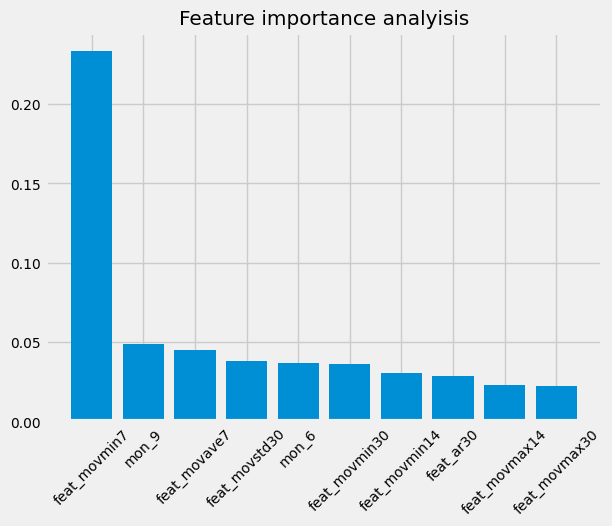

In [36]:
# Get feature importances from our random forest model
best_rfr_idx = CV_rfr_tup[2]
best_rfr_grid = rfr_paramGrid[best_rfr_idx]
best_rfr = RandomForestRegressor().set_params(**best_rfr_grid).fit(X_train, y_train)

importances = best_rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
sorted_index_top = sorted_index[:10]
x = range(len(sorted_index_top))

# Create tick labels 
labels = np.array(features)[sorted_index_top]
plt.bar(x, importances[sorted_index_top], tick_label=labels)
plt.title("Feature importance analyisis")
# Rotate tick labels to vertical
plt.xticks(rotation=45)
plt.show()

In [37]:
np.array(y_train)

array([[ 1.13718129,  1.06711466,  0.75328817, ..., -0.17066602,
         0.27771908,  0.30622996],
       [ 1.06711466,  0.75328817,  0.68466044, ...,  0.27771908,
         0.30622996,  0.44521728],
       [ 0.75328817,  0.68466044,  0.76403253, ...,  0.30622996,
         0.44521728,  0.28547363],
       ...,
       [-1.00147949, -0.44738269,  0.13073596, ..., -0.97171065,
        -0.77060941, -0.35096783],
       [-0.44738269,  0.13073596, -0.08179892, ..., -0.77060941,
        -0.35096783, -0.48556952],
       [ 0.13073596, -0.08179892, -0.29274842, ..., -0.35096783,
        -0.48556952, -0.90093749]])

In [38]:
p_train = best_rfr.predict(X_train)
train_resid_1step = np.array(y_train)- p_train

p_test = best_rfr.predict(X_test)
test_resid_1step = np.array(y_test)- p_test

In [39]:
MAE = mean_absolute_error(np.array(y_test), p_test)
MAPE_RF = mean_absolute_percentage_error(np.array(y_test), p_test)
MAPE_RF

2.384957830027203

In [40]:
import holidays


**Create the model with Prophet**


In [43]:
class PowerForcasting():

    def __init__(self, train_data,test_data, model_path):
        train_data.columns=['ds', 'y']
        test_data.columns=['ds', 'y']
        self.model_path = model_path
        self.train_data = train_data
        self.test_data = test_data
        holiday = pd.DataFrame()
        for date, name in sorted(holidays.UnitedStates(years=[2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]).items()):
            holiday = pd.concat([holiday, pd.DataFrame([{'ds': date, 'holiday': "US-Holidays"}])], axis=0, ignore_index=True)

        holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
        self.holiday = holiday
        self.model = self.train_save_final_model()



    def get_optimal_value_of_model(self):
        params_grid = {'seasonality_mode': ('multiplicative', 'additive'),
                       'changepoint_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5],
                       'holidays_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5],
                       'n_changepoints': [100, 150, 200]}
        grid = ParameterGrid(params_grid)
        cnt = 0
        for p in grid:
            cnt = cnt + 1

        print('Total Possible Models', cnt)
        model_parameters = pd.DataFrame(columns=['MAE', 'Parameters'])
        with strategy.scope():
            for p in grid:
                test = pd.DataFrame()
                print(p)
                random.seed(0)
                train_model = Prophet(changepoint_prior_scale=p['changepoint_prior_scale'],
                                      holidays_prior_scale=p['holidays_prior_scale'],
                                      n_changepoints=p['n_changepoints'],
                                      seasonality_mode=p['seasonality_mode'],
                                      weekly_seasonality=True,
                                      daily_seasonality=True,
                                      yearly_seasonality=True,
                                      holidays=self.holiday,
                                      interval_width=0.95)
                train_model.add_country_holidays(country_name='US')
                train_model.fit(self.train_data)
                test_forecast = train_model.predict(self.test_data)
                y_true = self.test_data['y']
                y_pred = test_forecast['yhat']
                MAPE = mean_absolute_percentage_error(y_true, y_pred)
                print('Mean Absolute Percent Error(MAPE)------------------------------------', MAPE)
                model_parameters = pd.concat([model_parameters, pd.DataFrame([{'MAPE': MAPE, 'Parameters': p}])], axis=0,
                                             ignore_index=True)
        best_parameters = model_parameters.iloc[model_parameters.MAPE.argmin()].Parameters
        return best_parameters

    def train_save_final_model(self):
        best_parameters = self.get_optimal_value_of_model()
        final_model = Prophet(holidays=self.holiday,
                              changepoint_prior_scale=best_parameters.get('changepoint_prior_scale'),
                              holidays_prior_scale=best_parameters.get('holidays_prior_scale'),
                              n_changepoints=best_parameters.get('n_changepoints'),
                              seasonality_mode=best_parameters.get('seasonality_mode'),
                              weekly_seasonality=False,
                              daily_seasonality=False,
                              yearly_seasonality=True,
                              interval_width=0.95)
        final_model.add_country_holidays(country_name='US')
        final_model.fit(self.train_data)
        self.model = final_model
        with open(self.model_path, 'w') as f:
            f.write(model_to_json(self.model))

**Train and Tune model**

In [44]:
model_path = "model.json"
power_forcasting = PowerForcasting(train_data, test_data, model_path)

Total Possible Models 150
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:15:26 - cmdstanpy - INFO - Chain [1] start processing
07:15:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.138129395606375
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:15:31 - cmdstanpy - INFO - Chain [1] start processing
07:15:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.10596743147027302
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:15:31 - cmdstanpy - INFO - Chain [1] start processing
07:15:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13801793717145894
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:15:36 - cmdstanpy - INFO - Chain [1] start processing
07:15:38 - cmdstanpy - INFO - Chain [1] done processing
07:15:38 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1064898550500044
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:15:46 - cmdstanpy - INFO - Chain [1] done processing
07:15:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13794564260963454
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:15:47 - cmdstanpy - INFO - Chain [1] done processing
07:15:48 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.10508464683825891
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:15:53 - cmdstanpy - INFO - Chain [1] done processing
07:15:53 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13676201370755522
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:15:54 - cmdstanpy - INFO - Chain [1] done processing
07:15:54 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.10605400374548972
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:15:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13850351876367625
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:16:00 - cmdstanpy - INFO - Chain [1] start processing
07:16:01 - cmdstanpy - INFO - Chain [1] done processing
07:16:01 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.10723988258354131
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:16:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13783617595912548
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:16:09 - cmdstanpy - INFO - Chain [1] start processing
07:16:10 - cmdstanpy - INFO - Chain [1] done processing
07:16:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1076506462114267
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:16:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.137107345526159
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:16:16 - cmdstanpy - INFO - Chain [1] start processing
07:16:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.10468992239668534
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:16:17 - cmdstanpy - INFO - Chain [1] start processing
07:16:23 - cmdstanpy - INFO - Chain [1] done processing
07:16:24 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13444594213501065
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:16:24 - cmdstanpy - INFO - Chain [1] done processing
07:16:25 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.10725634579311058
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:16:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13832543391805283
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:16:32 - cmdstanpy - INFO - Chain [1] start processing
07:16:33 - cmdstanpy - INFO - Chain [1] done processing
07:16:33 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.10704318432234904
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:16:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13800793843276093
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:16:35 - cmdstanpy - INFO - Chain [1] start processing
07:16:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.10669005104068073
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:16:36 - cmdstanpy - INFO - Chain [1] start processing
07:16:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13580537397767425
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:16:43 - cmdstanpy - INFO - Chain [1] start processing
07:16:44 - cmdstanpy - INFO - Chain [1] done processing
07:16:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.10667463219373893
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:16:53 - cmdstanpy - INFO - Chain [1] done processing
07:16:53 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13682292436346213
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:16:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1059187853111283
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:16:55 - cmdstanpy - INFO - Chain [1] start processing
07:17:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13393594995811112
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:17:01 - cmdstanpy - INFO - Chain [1] start processing
07:17:01 - cmdstanpy - INFO - Chain [1] done processing
07:17:02 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1088331356681919
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:17:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1358503187631615
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:17:09 - cmdstanpy - INFO - Chain [1] start processing
07:17:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.10639402550882998
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:17:11 - cmdstanpy - INFO - Chain [1] start processing
07:17:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.137419622755228
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:17:19 - cmdstanpy - INFO - Chain [1] start processing
07:17:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.10574887594708561
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:17:20 - cmdstanpy - INFO - Chain [1] start processing
07:17:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14140799765395848
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:17:26 - cmdstanpy - INFO - Chain [1] start processing
07:17:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1260721690685832
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:17:29 - cmdstanpy - INFO - Chain [1] start processing
07:17:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14233966771416534
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:17:36 - cmdstanpy - INFO - Chain [1] start processing
07:17:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1246881862826489
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:17:39 - cmdstanpy - INFO - Chain [1] start processing
07:17:47 - cmdstanpy - INFO - Chain [1] done processing
07:17:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.139162860635939
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:17:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.12322947818223096
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:17:50 - cmdstanpy - INFO - Chain [1] start processing
07:17:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14003794482646004
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:17:56 - cmdstanpy - INFO - Chain [1] start processing
07:17:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.12538316395177132
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:17:58 - cmdstanpy - INFO - Chain [1] start processing
07:18:04 - cmdstanpy - INFO - Chain [1] done processing
07:18:05 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14045258897547183
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:18:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.12552700308862036
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:18:07 - cmdstanpy - INFO - Chain [1] start processing
07:18:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1400265129514141
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:18:16 - cmdstanpy - INFO - Chain [1] start processing
07:18:19 - cmdstanpy - INFO - Chain [1] done processing
07:18:19 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.12246362127268096
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:18:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14183180882880683
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:18:26 - cmdstanpy - INFO - Chain [1] start processing
07:18:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.12443347082833478
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:18:28 - cmdstanpy - INFO - Chain [1] start processing
07:18:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14034470594837556
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:18:35 - cmdstanpy - INFO - Chain [1] start processing
07:18:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.12357897991529074
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:18:38 - cmdstanpy - INFO - Chain [1] start processing
07:18:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14014452135067557
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:18:51 - cmdstanpy - INFO - Chain [1] start processing
07:18:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.12429595686065165
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:18:55 - cmdstanpy - INFO - Chain [1] start processing
07:18:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13882230456414138
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:18:59 - cmdstanpy - INFO - Chain [1] start processing
07:19:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.12522414659767542
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:19:01 - cmdstanpy - INFO - Chain [1] start processing
07:19:07 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14029397689996148
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:19:08 - cmdstanpy - INFO - Chain [1] start processing
07:19:10 - cmdstanpy - INFO - Chain [1] done processing
07:19:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.12448442601838042
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:19:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1433151174017689
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:19:20 - cmdstanpy - INFO - Chain [1] start processing
07:19:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.12300302413424427
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:19:24 - cmdstanpy - INFO - Chain [1] start processing
07:19:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14033025895792042
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:19:29 - cmdstanpy - INFO - Chain [1] start processing
07:19:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.12477757706269021
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:19:32 - cmdstanpy - INFO - Chain [1] start processing
07:19:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14084439343106275
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:19:39 - cmdstanpy - INFO - Chain [1] start processing
07:19:41 - cmdstanpy - INFO - Chain [1] done processing
07:19:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.12419079297003054
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:19:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14149709369114072
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:19:50 - cmdstanpy - INFO - Chain [1] start processing
07:19:53 - cmdstanpy - INFO - Chain [1] done processing
07:19:53 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.12349817797839385
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:19:58 - cmdstanpy - INFO - Chain [1] done processing
07:19:58 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14973076947111477
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:20:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13054921283763044
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:20:01 - cmdstanpy - INFO - Chain [1] start processing
07:20:07 - cmdstanpy - INFO - Chain [1] done processing
07:20:07 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14898010466193962
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:20:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.12709048144577115
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:20:10 - cmdstanpy - INFO - Chain [1] start processing
07:20:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1438996443444383
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:20:19 - cmdstanpy - INFO - Chain [1] start processing
07:20:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1291434214365714
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:20:23 - cmdstanpy - INFO - Chain [1] start processing
07:20:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14860136736665777
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:20:28 - cmdstanpy - INFO - Chain [1] start processing
07:20:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13049495675615796
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:20:31 - cmdstanpy - INFO - Chain [1] start processing
07:20:37 - cmdstanpy - INFO - Chain [1] done processing
07:20:38 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1478826967859076
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:20:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.12938959930199703
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:20:40 - cmdstanpy - INFO - Chain [1] start processing
07:20:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.15458133303424548
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:20:49 - cmdstanpy - INFO - Chain [1] start processing
07:20:52 - cmdstanpy - INFO - Chain [1] done processing
07:20:52 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1282038492187384
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:20:57 - cmdstanpy - INFO - Chain [1] done processing
07:20:57 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1473804254419839
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:20:59 - cmdstanpy - INFO - Chain [1] done processing
07:21:00 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13071351091387168
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:21:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.15030140074784454
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:21:07 - cmdstanpy - INFO - Chain [1] start processing
07:21:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1289867730068718
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:21:10 - cmdstanpy - INFO - Chain [1] start processing
07:21:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14666477581315207
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:21:16 - cmdstanpy - INFO - Chain [1] start processing
07:21:21 - cmdstanpy - INFO - Chain [1] done processing
07:21:21 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.12887737618451717
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:21:25 - cmdstanpy - INFO - Chain [1] done processing
07:21:26 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14519842652490164
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:21:28 - cmdstanpy - INFO - Chain [1] done processing
07:21:28 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1305879589086353
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:21:35 - cmdstanpy - INFO - Chain [1] done processing
07:21:35 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1476395816041138
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:21:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1306515180356765
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:21:38 - cmdstanpy - INFO - Chain [1] start processing
07:21:46 - cmdstanpy - INFO - Chain [1] done processing
07:21:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14710771197423617
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:21:49 - cmdstanpy - INFO - Chain [1] done processing
07:21:50 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1300791200709765
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:21:54 - cmdstanpy - INFO - Chain [1] done processing
07:21:55 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1467990163062561
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:21:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.12872748858294306
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:21:57 - cmdstanpy - INFO - Chain [1] start processing
07:22:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14506245880569937
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:22:03 - cmdstanpy - INFO - Chain [1] start processing
07:22:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13011130154926853
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:22:06 - cmdstanpy - INFO - Chain [1] start processing
07:22:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14747696894099446
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:22:14 - cmdstanpy - INFO - Chain [1] start processing
07:22:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1297867080048421
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:22:19 - cmdstanpy - INFO - Chain [1] start processing
07:22:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14877013192653443
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:22:24 - cmdstanpy - INFO - Chain [1] start processing
07:22:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13385090532552024
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:22:26 - cmdstanpy - INFO - Chain [1] start processing
07:22:29 - cmdstanpy - INFO - Chain [1] done processing
07:22:29 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14308262849413575
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:22:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13296768263067504
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:22:33 - cmdstanpy - INFO - Chain [1] start processing
07:22:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14580589362769794
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:22:38 - cmdstanpy - INFO - Chain [1] start processing
07:22:44 - cmdstanpy - INFO - Chain [1] done processing
07:22:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1327432682166731
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:22:47 - cmdstanpy - INFO - Chain [1] done processing
07:22:48 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14838895318359005
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:22:50 - cmdstanpy - INFO - Chain [1] done processing
07:22:50 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1337858616153647
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:22:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.148313360585777
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:22:56 - cmdstanpy - INFO - Chain [1] start processing
07:23:00 - cmdstanpy - INFO - Chain [1] done processing
07:23:00 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13195638098718696
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:23:08 - cmdstanpy - INFO - Chain [1] done processing
07:23:08 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.15351969754629644
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:23:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13285865578415484
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:23:12 - cmdstanpy - INFO - Chain [1] start processing
07:23:16 - cmdstanpy - INFO - Chain [1] done processing
07:23:17 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14829981898526082
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:23:19 - cmdstanpy - INFO - Chain [1] done processing
07:23:20 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1329220650723768
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:23:26 - cmdstanpy - INFO - Chain [1] done processing
07:23:26 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1471455789736922
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:23:30 - cmdstanpy - INFO - Chain [1] done processing
07:23:30 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1333065867780448
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:23:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.15057177241965342
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:23:38 - cmdstanpy - INFO - Chain [1] start processing
07:23:43 - cmdstanpy - INFO - Chain [1] done processing
07:23:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13233846495054838
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:23:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14950839947269437
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:23:49 - cmdstanpy - INFO - Chain [1] start processing
07:23:51 - cmdstanpy - INFO - Chain [1] done processing
07:23:52 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13356744111216123
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:23:58 - cmdstanpy - INFO - Chain [1] done processing
07:23:58 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14791687983917745
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:24:03 - cmdstanpy - INFO - Chain [1] done processing
07:24:03 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13365149660008543
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:24:11 - cmdstanpy - INFO - Chain [1] done processing
07:24:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1527065828108356
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:24:15 - cmdstanpy - INFO - Chain [1] done processing
07:24:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13183559546738063
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:24:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14608053574966112
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:24:21 - cmdstanpy - INFO - Chain [1] start processing
07:24:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13361297080913115
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:24:24 - cmdstanpy - INFO - Chain [1] start processing
07:24:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.15214876534198354
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:24:31 - cmdstanpy - INFO - Chain [1] start processing
07:24:34 - cmdstanpy - INFO - Chain [1] done processing
07:24:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13195121538514212
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:24:40 - cmdstanpy - INFO - Chain [1] done processing
07:24:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14836063374616684
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:24:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13275379625065128
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:24:46 - cmdstanpy - INFO - Chain [1] start processing
07:24:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14966965248710767
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:24:51 - cmdstanpy - INFO - Chain [1] start processing
07:24:54 - cmdstanpy - INFO - Chain [1] done processing
07:24:55 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1365659816726106
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:25:01 - cmdstanpy - INFO - Chain [1] done processing
07:25:01 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.15328121887432838
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:25:05 - cmdstanpy - INFO - Chain [1] done processing
07:25:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1345763083220205
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:25:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.14998795175054438
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:25:13 - cmdstanpy - INFO - Chain [1] start processing
07:25:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13363133536715852
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:25:17 - cmdstanpy - INFO - Chain [1] start processing
07:25:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1543091160955471
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:25:23 - cmdstanpy - INFO - Chain [1] start processing
07:25:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13590449720789585
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:25:26 - cmdstanpy - INFO - Chain [1] start processing
07:25:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.15139266949143027
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:25:33 - cmdstanpy - INFO - Chain [1] start processing
07:25:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13423706183693918
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:25:39 - cmdstanpy - INFO - Chain [1] start processing
07:25:47 - cmdstanpy - INFO - Chain [1] done processing
07:25:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.15767619363036112
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:25:52 - cmdstanpy - INFO - Chain [1] done processing
07:25:52 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13392794800660698
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:25:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.15070557506577315
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:25:56 - cmdstanpy - INFO - Chain [1] start processing
07:25:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13603986816440594
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:25:59 - cmdstanpy - INFO - Chain [1] start processing
07:26:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1504431368930462
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:26:05 - cmdstanpy - INFO - Chain [1] start processing
07:26:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13461923733806055
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:26:09 - cmdstanpy - INFO - Chain [1] start processing
07:26:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.15214863576100207
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:26:18 - cmdstanpy - INFO - Chain [1] start processing
07:26:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1328302105876058
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:26:24 - cmdstanpy - INFO - Chain [1] start processing
07:26:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.15750280262765692
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:26:30 - cmdstanpy - INFO - Chain [1] start processing
07:26:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13616784021261844
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:26:33 - cmdstanpy - INFO - Chain [1] start processing
07:26:40 - cmdstanpy - INFO - Chain [1] done processing
07:26:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.15375082047025102
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:26:45 - cmdstanpy - INFO - Chain [1] done processing
07:26:45 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1340811412716738
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:26:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.15611693743024616
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:26:54 - cmdstanpy - INFO - Chain [1] start processing
07:27:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13431085676052282
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


07:27:00 - cmdstanpy - INFO - Chain [1] start processing
07:27:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1517686059748826
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


07:27:05 - cmdstanpy - INFO - Chain [1] start processing
07:27:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1352597773987401
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


07:27:08 - cmdstanpy - INFO - Chain [1] start processing
07:27:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.15506499478032568
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


07:27:15 - cmdstanpy - INFO - Chain [1] start processing
07:27:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1340268045489584
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


07:27:19 - cmdstanpy - INFO - Chain [1] start processing
07:27:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.1502796213363004
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


07:27:28 - cmdstanpy - INFO - Chain [1] start processing
07:27:33 - cmdstanpy - INFO - Chain [1] done processing
07:27:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percent Error(MAPE)------------------------------------ 0.13378394427000204


07:27:34 - cmdstanpy - INFO - Chain [1] done processing


**Load model**

In [45]:
with open(model_path, 'r') as f:
    final_model = model_from_json(f.read())
test_data.columns=['ds', 'y']


C:\Users\vudod\anaconda3\envs\test\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


**Test/Evaluate model**

In [46]:
power_test_fcst_with_hols = final_model.predict(test_data)

In [47]:
power_test_fcst_with_hols

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-01-06,744572.066731,647569.046218,9.279755e+05,744572.066731,744573.214825,0.0,0.0,0.0,0.0,...,0.059634,0.059634,0.059634,0.059634,0.059634,0.059634,0.0,0.0,0.0,788974.200037
1,2016-01-07,744525.625241,637048.056172,9.433041e+05,744520.312257,744535.924759,0.0,0.0,0.0,0.0,...,0.063527,0.063527,0.063527,0.063527,0.063527,0.063527,0.0,0.0,0.0,791822.891028
2,2016-01-08,744479.183750,654253.529766,9.360730e+05,744465.636611,744510.082304,0.0,0.0,0.0,0.0,...,0.067387,0.067387,0.067387,0.067387,0.067387,0.067387,0.0,0.0,0.0,794647.210950
3,2016-01-09,744432.742260,657836.135899,9.477293e+05,744408.432918,744479.745403,0.0,0.0,0.0,0.0,...,0.071170,0.071170,0.071170,0.071170,0.071170,0.071170,0.0,0.0,0.0,797414.154666
4,2016-01-10,744386.300770,642080.177499,9.359757e+05,744349.099864,744449.983834,0.0,0.0,0.0,0.0,...,0.074833,0.074833,0.074833,0.074833,0.074833,0.074833,0.0,0.0,0.0,800091.152096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,2018-07-30,701102.831984,604909.871257,1.044717e+06,552634.362516,844891.915160,0.0,0.0,0.0,0.0,...,0.176597,0.176597,0.176597,0.176597,0.176597,0.176597,0.0,0.0,0.0,824915.525962
937,2018-07-31,701056.390494,606026.051570,1.061687e+06,552495.439799,845065.627143,0.0,0.0,0.0,0.0,...,0.168060,0.168060,0.168060,0.168060,0.168060,0.168060,0.0,0.0,0.0,818875.874319
938,2018-08-01,701009.949003,593797.418231,1.030948e+06,552356.517083,845239.339125,0.0,0.0,0.0,0.0,...,0.159659,0.159659,0.159659,0.159659,0.159659,0.159659,0.0,0.0,0.0,812932.189062
939,2018-08-02,700963.507513,586791.015278,1.023215e+06,552217.594366,845408.655625,0.0,0.0,0.0,0.0,...,0.151506,0.151506,0.151506,0.151506,0.151506,0.151506,0.0,0.0,0.0,807163.553757


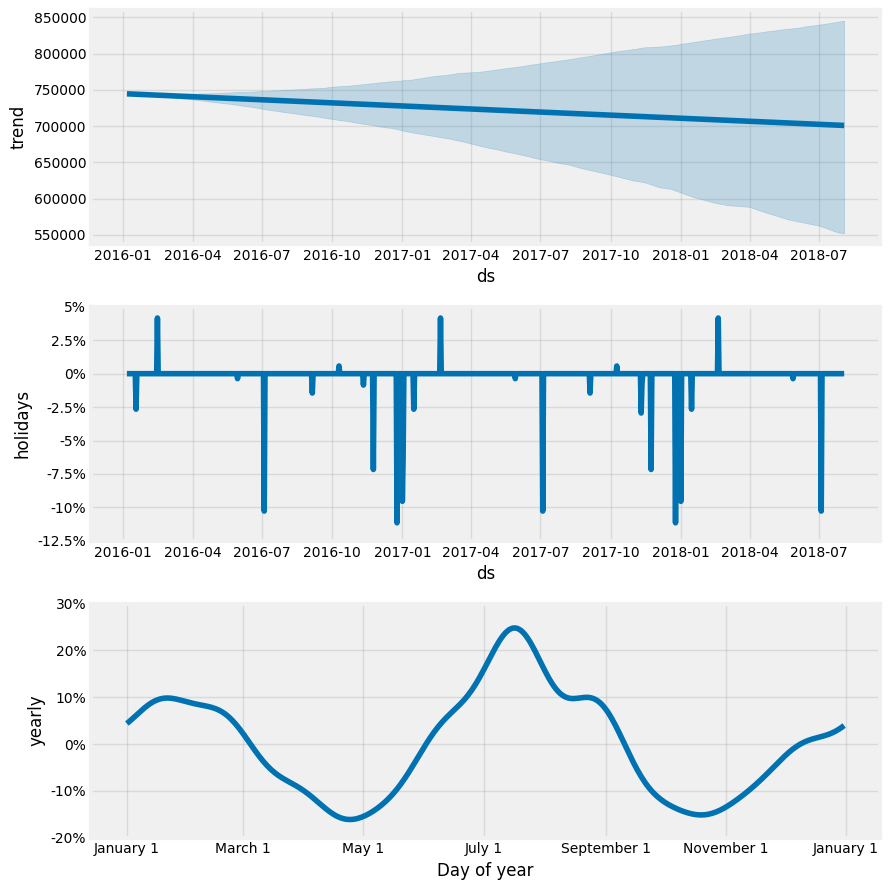

In [48]:
fig2 = final_model.plot_components(power_test_fcst_with_hols)


In [49]:
future = final_model.make_future_dataframe(periods=30, freq='D')
forecast = final_model.predict(future)



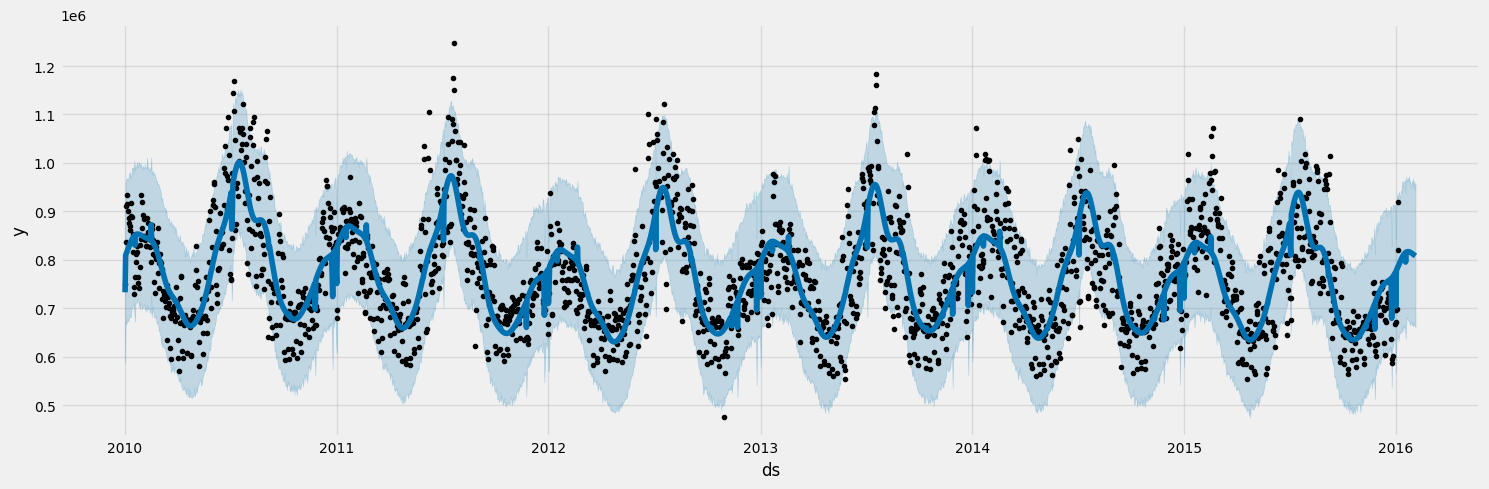

In [50]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model.plot(forecast,ax=ax)
plt.show()

In [51]:
X_tst_final= final_model.predict(test_data)


In [52]:
X_tst_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)


,ds,yhat,yhat_lower,yhat_upper
934,2018-07-28,836946.495466,627311.010202,1.053801e+06
935,2018-07-29,830967.737675,624385.427344,1.048059e+06
936,2018-07-30,824915.525962,628383.373764,1.049381e+06
937,2018-07-31,818875.874319,609634.164333,1.044597e+06
938,2018-08-01,812932.189062,604729.568545,1.043768e+06
939,2018-08-02,807163.553757,605012.490805,1.013171e+06
940,2018-08-03,801643.113748,599902.738399,1.010813e+06


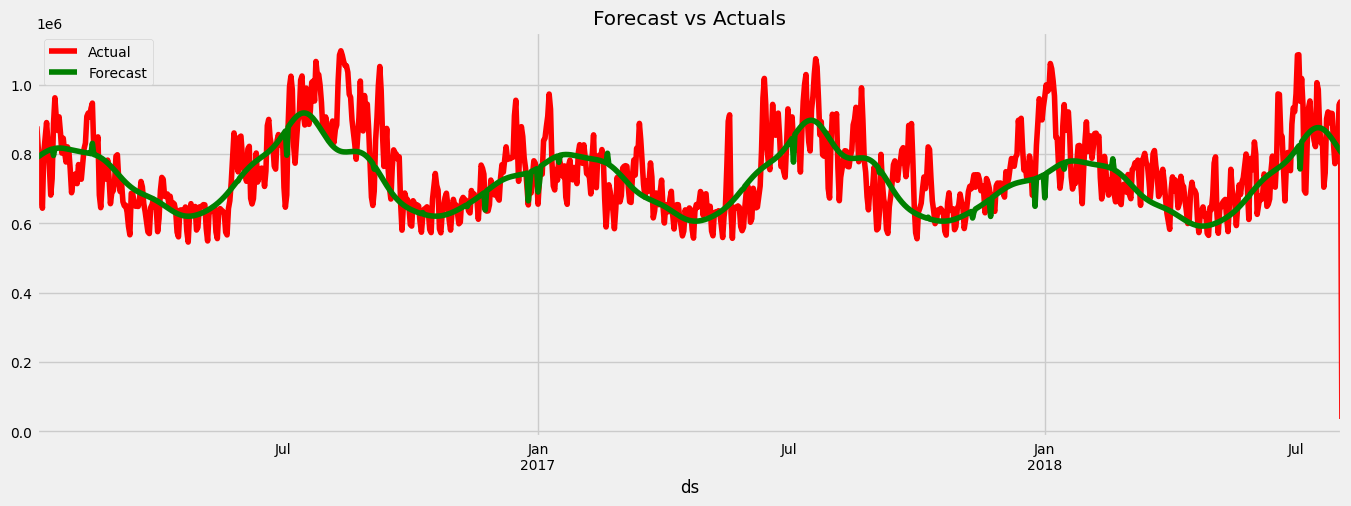

In [53]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
test_data.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

**Model performance**

Assessment will be carried out computing MAE (Mean Absolute Error) for each forecating horizong on a holdout dataset


In [54]:
y_true = test_data['y']
y_p = X_tst_final['yhat']
MAPE_PR = mean_absolute_percentage_error(y_true, y_p)
print(MAPE_PR)

0.10848356566526562


## Compare performance of each algorithm


Model building objectives:

Train a Machine Learning model being able to forecast (predict on future data) 30 periods ahead
Feature Engineering process is automatic and no assumptions on data statistical properties is required
Assessment will be carried out computing MAPE (Mean Absolute Percent Error) for each forecating horizong on a holdout dataset

Performance Metrics: MAPE (Mean Absolute Percent Error)
Even though RMSE is a very common performance metric, MAPE is very suitable to use, and much easer to understand and communicate. Let's use one period ahead model to compute MAPE in test period


$MAPE = \frac{1}{N}\sum_{i=1}^{N}\frac{|y-\hat{y}|}{y}$d

In [67]:
result = {'Baseline':MAPE_BL, 'Random Forest':MAPE_RF, 'Prophet':MAPE_PR}
result

{'Baseline': 1.6886425576058097,
 'Random Forest': 2.384957830027203,
 'Prophet': 0.10848356566526562}

Text(0.5, 1.0, 'MAPE of each algorithm')

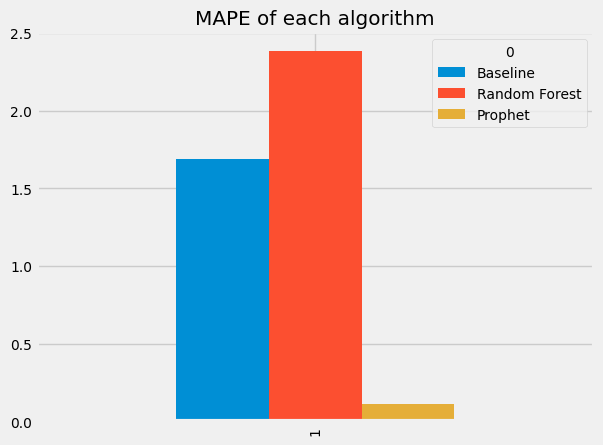

In [70]:
output = pd.DataFrame.from_dict(result.items()).set_index(0).T
output.plot.bar()
plt.title("MAPE of each algorithm")


**The Forecasting with Prophet returns the best performance with MAPE is 0.1 in comparison with the MAPE of BL 1.67 and MAPE of RF 2.51, hence we choose it for the forecasting model**


https://en.wikipedia.org/wiki/Mean_absolute_percentage_error

**Test forecasting with a given date**

In [64]:

date_str = '07/28/2018'
date_format = '%m/%d/%Y'

date_obj = dt.datetime.strptime(date_str, date_format)

date_obj
test_date = {'ds':date_obj}
output = final_model.predict(pd.DataFrame([test_date]))
print(output)
result = {"date": output.ds, "power forcasting":output.yhat}
print(result)

          ds          trend     yhat_lower     yhat_upper    trend_lower  \
0 2018-07-28  701195.714964  685861.103444  980948.512665  701195.714964   

     trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0  701195.714964            0.0                  0.0                  0.0   

   Christmas Day (Observed)  ...  multiplicative_terms  \
0                       0.0  ...              0.193599   

   multiplicative_terms_lower  multiplicative_terms_upper    yearly  \
0                    0.193599                    0.193599  0.193599   

   yearly_lower  yearly_upper  additive_terms  additive_terms_lower  \
0      0.193599      0.193599             0.0                   0.0   

   additive_terms_upper           yhat  
0                   0.0  836946.495466  

[1 rows x 64 columns]
{'date': 0   2018-07-28
Name: ds, dtype: datetime64[ns], 'power forcasting': 0    836946.495466
Name: yhat, dtype: float64}
